## U-Netセグメンテーション

In [1]:
import os
import glob

import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### データ読み込みの準備
テキストファイルをもとにセグメンテーション用画像のパスのリストを作る

In [2]:
train_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
val_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

def txt_to_pathlist(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]

        image_paths = ["./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/"+fn+".jpg" for fn in lines]
        label_paths = ["./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass/"+fn+".png" for fn in lines]
    return image_paths, label_paths

train_image_paths, train_label_paths = txt_to_pathlist(train_path)
v_image_paths, v_label_paths = txt_to_pathlist(val_path)
middle = len(v_image_paths)//2
val_image_paths = v_image_paths[:middle]
val_label_paths = v_label_paths[:middle]
test_image_paths = v_image_paths[middle:]
test_label_paths = val_label_paths[middle:]

print(len(train_image_paths), len(val_image_paths), len(test_image_paths))


1464 724 725


データセットクラスの作成

In [3]:
class SegmentDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.cls_idx = [i for i in range(22)]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.resize((128,128)) 
        image = np.asarray(image)
        image = torch.from_numpy(image.astype(np.float32)).clone()
        image = image.permute(2,0,1) #次元の並び替え

        label = Image.open(self.label_paths[idx])
        label = label.resize((128,128))
        label = np.asarray(label)
        label = np.where(label == 255, 21, label) # 境界線マスクを255から21に変更

        #onehotベクトル化        
        label = torch.from_numpy(label).long().clone()
        #label = torch.nn.functional.one_hot(label.long()).to(torch.float32)
        #label = label.permute(2,0,1)

        return image, label

In [4]:
training_data = SegmentDataset(train_image_paths, train_label_paths)
validation_data = SegmentDataset(val_image_paths, val_label_paths)
test_data = SegmentDataset(test_image_paths, test_label_paths)

In [5]:
batch_size = 16

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([16, 3, 128, 128])
Shape of y:  torch.Size([16, 128, 128]) torch.int64


### U-Netの定義

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding="same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(3, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.UC1 = UpConv(1024, 512) 
        self.UC2 = UpConv(512, 256) 
        self.UC3 = UpConv(256, 128) 
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 22, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)
        #x = self.soft(x)

        return x
    
model = UNet_2D().to(device)
#print(model)

Using cuda device


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def calc_metrics(pred, tgt):

    dice_list = []
    present_dice_list = []

    for c in range(21):
        #onehot化
        tgt_mask = F.one_hot(tgt, 22)
        pred_mask = torch.argmax(pred, dim=1)
        pred_mask = F.one_hot(pred_mask, 22)
        tgt_mask = tgt_mask[:,:,:,c+1]
        pred_mask = pred_mask[:,:,:,c+1]
        if tgt_mask.sum().item() == 0:
            dice = float("nan")
        else:
            tp = torch.logical_and(tgt_mask, pred_mask).sum().item()
            fp = torch.logical_and(~tgt_mask, pred_mask).sum().item()
            fn = torch.logical_and(tgt_mask, ~pred_mask).sum().item()
            dice = 2*tp/(2*tp+fp+fn)
            present_dice_list.append(dice)

    return np.mean(present_dice_list)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [10]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss = 0
    dices = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            dice = calc_metrics(pred, y)
            dices.append(dice)

    validation_loss /= size
    mdice = np.mean(dices)
    print(f"Validation Error: \n mean Dice: {(mdice):.3f}, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

validation損失をもとに最適epochを決定


In [12]:
epochs = 10
min_loss = 1000
model_path = "model/unet/"
result_dir = "result/"

os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), "./model/model_"+str(t+1)+".pth")
print(best_epoch)

model = UNet_2D()
#model.load_state_dict(torch.load("model/model_"+str(best_epoch)+".pth"))
#test(test_dataloader, model)

print("Done!")

Epoch 1
-------------------------------


c:\Users\Tonomura\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 3.250236  [    0/ 1464]
loss: 2.904750  [  800/ 1464]
Validation Error: 
 mean Dice: 0.026, Avg loss: 0.173246 

Epoch 2
-------------------------------
loss: 2.650131  [    0/ 1464]
loss: 2.378981  [  800/ 1464]
Validation Error: 
 mean Dice: 0.023, Avg loss: 0.144794 

Epoch 3
-------------------------------
loss: 2.202555  [    0/ 1464]
loss: 2.012324  [  800/ 1464]


損失グラフ作成

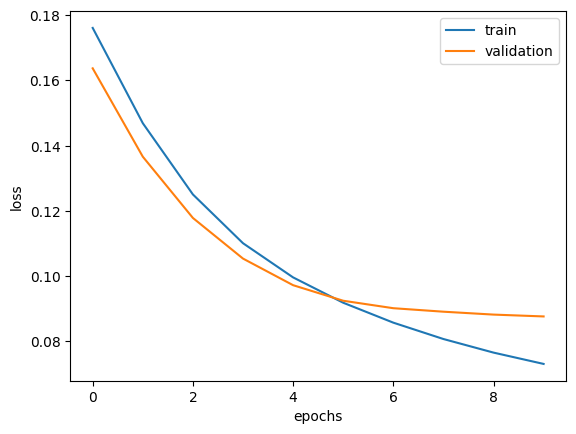

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


結果の評価